# Article Emulation for Frequent Bigrams

In [1]:
import os
import re

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
import pymorphy2 as pm2

### 0. Introduction

В прошлый раз анализировались достаточно редкие по частотности биграммы. Попробуем решить те же задачи для самых частотных. 

Критерии отбора биграмм:
1. частотность определяется по документам (df);
2. биграмма должна иметь соответствующую статью-эталон на википедии.

Будем выбирать биграммы, исходя из следующей диаграммы частот:

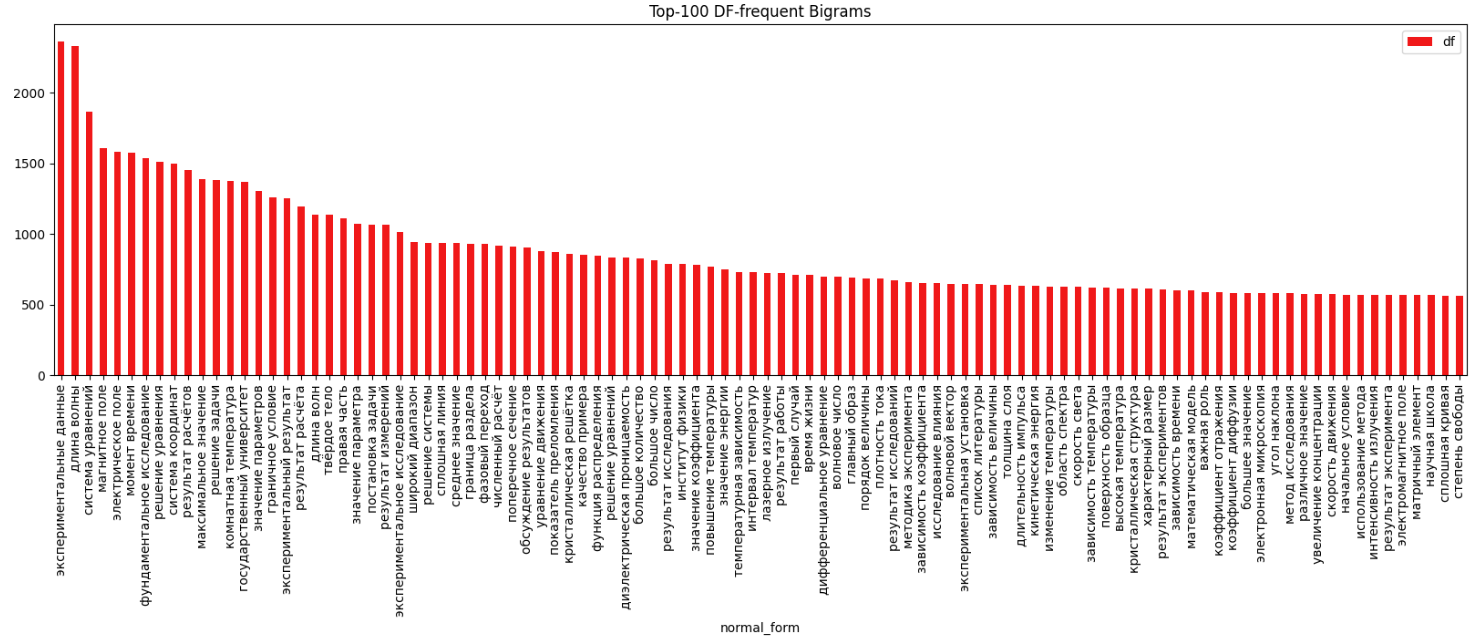

Отберем по заданным критериям 10 биграмм:

In [2]:
top10_wikigrams = {
    'длина_волна',
    'система_уравнение',
    'магнитный_поле',
    'электрический_поле',
    'момент_время',
    'решение_уравнение',
    'система_координата',
    'решение_задача',
    'комнатный_температура',
    'твёрдый_тело',
}

### 1. Data Preprocessing

#### 1.1 Loading corpus

Загрузим датасет - корпус научных статей по физике:

In [3]:
data_directory = '../data/elibrary_physics_15k'
article_id = re.compile(r'_([0-9]+).htm$')

file_contents = []
for filename in tqdm(os.scandir(data_directory), desc='Loading data'):
    if filename.is_file():
        file_name = filename.name
        file_id = int(article_id.search(file_name).groups(1)[0])
        
        with open(filename, "r", encoding='utf-8') as f:
            text = f.read()
            file_contents.append((file_id, text))

print(f'Размер корпуса: {len(file_contents)} статей')

Loading data: 0it [00:00, ?it/s]

Размер корпуса: 15000 статей


#### 1.2 Filtering out non-russian articles

Удалим из корпуса статьи, написанные не на русском языке.

In [4]:
MIN_CYRILLIC_THRESHOLD = 0.2

cyrillic_sym = re.compile(r'[а-яёА-ЯЁ]')

Алгоритм отсеивания статей по языку:
1. подсчитывается кол-во кириллических символов в статье;
2. если соотношение кириллицы >= MIN_CYRILLIC_THRESHOLD -> статья русскоязычная.

In [5]:
rus_articles = []

for article in tqdm(file_contents, desc='Filtering out non-russian articles'):
    rus_count = 0
    for _ in cyrillic_sym.finditer(article[1]):
        rus_count += 1

    if rus_count >= len(article[1]) * MIN_CYRILLIC_THRESHOLD:
        rus_articles.append(article)

print(f'Удалено нерусскоязычных статей: {len(file_contents) - len(rus_articles)}')

Filtering out non-russian articles:   0%|          | 0/15000 [00:00<?, ?it/s]

Удалено нерусскоязычных статей: 4062


In [6]:
articles_count = len(rus_articles)
print(f'Кол-во русскоязычных статей: {articles_count}')

Кол-во русскоязычных статей: 10938


#### 1.3 Arranging lemmatizing procedures

Напишем вспомогательные функции для анализа лемм:

In [7]:
lemmatizer = pm2.MorphAnalyzer(lang='ru')
pm2_cache = {}

In [8]:
def match_bigram(word1_parse, word2_parse):
    """
    Tries to match bigram of w1 and w2 with any of the patterns.
    If succeed, returns a tuple ((w1_norm, w2_norm), pattern).
    """
    word1_pos = word1_parse.tag.POS
    word2_pos = word2_parse.tag.POS

    # failed pattern matching
    if word2_pos != 'NOUN' or word1_pos not in {'NOUN', 'ADJF'}:
        return None

    word1_inflection = (word1_parse.tag.gender, word1_parse.tag.number, word1_parse.tag.case)
    word2_inflection = (word2_parse.tag.gender, word2_parse.tag.number, word2_parse.tag.case)

    # 'adj + noun' pattern
    if (
        word1_pos == 'ADJF' and word2_pos == 'NOUN' 
        and word1_inflection[1] == word2_inflection[1]
        and word1_inflection[2] == word2_inflection[2]
        and (
            word1_inflection[0] == word2_inflection[0]
            or word1_inflection[0] is None and word1_inflection[1] == 'plur'
        )
    ):
        return (word1_parse.normal_form, word2_parse.normal_form), 'прил. + сущ.'

    # 'noun + noun' pattern
    if word1_pos == 'NOUN' and word2_pos == 'NOUN' and word2_inflection[2] == 'gent':
        return (word1_parse.normal_form, word2_parse.normal_form), 'сущ. + сущ.'

    return None

Зададим список стоп-слов:

In [9]:
stop_words = stopwords.words('russian')

stop_words.extend(
    [
        # adjective-like pronouns
        'мой', 'твой', 'ваш', 'наш', 'свой', 'его', 'ее', 'их',
        'тот', 'этот', 'такой', 'таков', 'сей', 'который',
        'весь', 'всякий', 'сам', 'самый', 'каждый', 'любой', 'иной', 'другой',
        'какой', 'каков', 'чей', 'никакой', 'ничей',
        'какой-то', 'какой-либо', 'какой-нибудь', 'некоторый', 'некий',
        # participles
        'соответствующий', 'следующий', 'данный',
        # numerals
        'один',
        # insignificant words
        'друг',
    ]
)

stop_words = set(stop_words)

Зададим список стоп-биграмм:

In [10]:
stop_bigrams = []

stop_bigrams.extend(
    [
        ('крайний', 'мера'), ('сегодняшний', 'день'), ('настоящий', 'время'), ('настоящий', 'работа'),
        ('настоящий', 'статья'), ('точка', 'зрение'), ('первый', 'очередь'), ('последний', 'год'),
    ]
)

stop_bigrams = set(stop_bigrams)

Подходящие слова должны содержать только буквы и дефисы (последние не в начале/конце слова):

In [11]:
def match_unigram(word):
    """Checks if a word is long enough and contains only letters and dashes."""
    if word.startswith('-') or word.endswith('-'):
        return False

    word_dashless = word.replace('-', '')
    return len(word_dashless) >= 3 and word_dashless.isalpha()

Bottleneck лемматизации - обращения к pymorphy2. Сократим кол-во обращений к анализатору, кешируя морфологические разборы токенов:

In [12]:
def get_or_cache_token_parse(lemmatizer, token, cache):
    """Extracts token parse from cache, or adds it to the latter if not found."""
    if token in cache:
        token_parse = cache[token]
    else:
        token_parse = lemmatizer.parse(token)[0]
        cache[token] = token_parse

    return token_parse

Реализуем единый интерфейс сохранения tf для n-грамм:

In [13]:
def update_tf_stats(n_gram_info, n_gram_collection, n):
    """Updates n-gram TF statistics with given n-gram."""
    # unigram
    if n == 1:
        if n_gram_info not in n_gram_collection:
            n_gram_collection[n_gram_info] = {
                'TF': 1,
                'DF': 0,
            }
        else:
            n_gram_collection[n_gram_info]['TF'] += 1
    # bigram
    elif n == 2:
        n_gram, n_gram_pattern = n_gram_info
        if n_gram not in n_gram_collection:
            n_gram_collection[n_gram] = {
                'Articles': [],
                'Pattern': n_gram_pattern,
                'TF': 1,
                'DF': 0,
            }
        else:
            n_gram_collection[n_gram]['TF'] += 1

*Следующий шаг **не нужно выполнять**, если биграммы уже записаны в датафрейм.*

Сохраним о каждой подходящей биграмме следующую информацию:
- список статей, где была встречена биграмма;
- тип биграммы (прил. + сущ. | сущ. + сущ.);
- частота встречаемости (TF);
- подокументная частота (DF).

In [33]:
pm2_cache, bigram_stats, unigram_stats = {}, {}, {}
corpus_size = 0

for article_id, article_text in tqdm(rus_articles, desc='Lemmatizing articles'):
    # tokenization
    tokens = word_tokenize(article_text.lower(), language='russian')

    # short and/or non-letter words removal
    standardized_tokens = []
    for token in tokens:
        if match_unigram(token):
            standardized_tokens.append(token)

    prev_unigram = None
    unique_bigrams, unique_unigrams = set(), set()
    for i in range(len(standardized_tokens) - 1):
        token1, token2 = standardized_tokens[i], standardized_tokens[i + 1]

        # bigram parse data extraction
        token1_parse = get_or_cache_token_parse(lemmatizer, token1, pm2_cache)
        token2_parse = get_or_cache_token_parse(lemmatizer, token2, pm2_cache)

        # stop-words removal
        if token1_parse.normal_form in stop_words or token2_parse.normal_form in stop_words:
            continue

        # bigram extraction
        bigram_info = match_bigram(token1_parse, token2_parse)
        if bigram_info is not None:
            bigram, bigram_pattern = bigram_info

            # stop-bigrams removal
            if bigram in stop_bigrams:
                continue

            unique_bigrams.add(bigram)
            unique_unigrams.update(bigram)

            # bigram TF statistics update
            update_tf_stats(bigram_info, bigram_stats, 2)

            # unigram TF statistics update
            if bigram[0] != prev_unigram:
                corpus_size += 1
                update_tf_stats(bigram[0], unigram_stats, 1)

            prev_unigram = bigram[1]
            corpus_size += 1
            update_tf_stats(bigram[1], unigram_stats, 1)

    # DF statistics update
    for bigram in unique_bigrams:
        bigram_stats[bigram]['DF'] += 1
        bigram_stats[bigram]['Articles'].append(article_id)
    for unigram in unique_unigrams:
        unigram_stats[unigram]['DF'] += 1

Lemmatizing articles:   0%|          | 0/10938 [00:00<?, ?it/s]

In [34]:
print(f'Количество подходящих униграмм: {corpus_size}')

Количество подходящих униграмм: 6546389


In [35]:
print(f'Количество подходящих биграмм: {len(bigram_stats)}')

Количество подходящих биграмм: 661886


#### 1.4 Saving extracted data

Оставим биграммы, удовлетворяющие условию **df >= 10**:

In [36]:
relevant_bigrams = {}

for bigram, stats in bigram_stats.items():
    if stats['DF'] >= 10:
        relevant_bigrams[bigram] = stats

In [37]:
bigram_df = pd.DataFrame(relevant_bigrams).T.reset_index()
bigram_df.rename(
    columns={
        'level_0': 'unigram_1',
        'level_1': 'unigram_2',
        'Articles': 'articles_id_list',
        'Pattern': 'pos_pattern',
        'TF': 'tf',
        'DF': 'df',
    },
    inplace=True,
)

bigram_df = bigram_df[['unigram_1', 'unigram_2', 'pos_pattern', 'tf', 'df', 'articles_id_list']]

bigram_df

,unigram_1,unigram_2,pos_pattern,tf,df,articles_id_list
0,многолетний,исследование,прил. + сущ.,12,12,"[10007645, 10268701, 11517634, 11533210, 11663..."
1,свойство,материал,сущ. + сущ.,824,532,"[10007645, 10008521, 10019725, 10022827, 10024..."
2,коррозионный,среда,прил. + сущ.,28,15,"[10007645, 10341547, 11522763, 11527623, 11532..."
3,накопление,повреждение,сущ. + сущ.,96,38,"[10007645, 10293693, 10293732, 10332644, 10337..."
4,материал,конструкция,сущ. + сущ.,54,44,"[10007645, 10026586, 10293693, 10293734, 10332..."
...,...,...,...,...,...,...
36538,одновременный,анализ,прил. + сущ.,10,10,"[12159364, 12194920, 12449931, 9465279, 951087..."
36539,отклонение,длина,сущ. + сущ.,11,10,"[12161418, 9321704, 9482639, 9510694, 9526520,..."
36540,механизм,стабилизация,сущ. + сущ.,24,17,"[12161488, 9446517, 9490650, 9495211, 9496635,..."
36541,число,функция,сущ. + сущ.,19,13,"[12162954, 12328115, 12450121, 9433550, 946953..."


Оставим униграммы, удовлетворяющие условию **df >= 10**:

In [38]:
unigram_df = pd.DataFrame(unigram_stats).T.reset_index()
unigram_df.rename(
    columns={
        'index': 'normal_form',
        'TF': 'tf',
        'DF': 'df',
    },
    inplace=True,
)
unigram_df = unigram_df[unigram_df['df'] >= 10].reset_index(drop=True)

unigram_df

,normal_form,tf,df
0,многолетний,58,49
1,исследование,22829,7669
2,учёный,487,269
3,эксплуатационный,334,249
4,среда,14040,3399
...,...,...,...
10128,кгт,14,12
10129,шварц,46,16
10130,тонкоструктурный,30,11
10131,импуля,11,11


Сохраним информацию об n-граммах:

In [39]:
bigram_df.to_csv('../data/data_frames/bigram_stats_full.csv')
unigram_df.to_csv('../data/data_frames/unigram_stats_full.csv')

### 2. Statistics Counting

*Всегда теперь будем **только подгружать** сгенерированные датафреймы.*

In [14]:
bigram_df = pd.read_csv('../data/data_frames/bigram_stats_full.csv', index_col=0)
unigram_df = pd.read_csv('../data/data_frames/unigram_stats_full.csv', index_col=0)

corpus_size = 6546389

Посчитаем метрики tf-idf и mi3 для биграмм.

#### 2.1 TF-IDF

In [15]:
idf = bigram_df['df'].apply(lambda x: np.log10(articles_count / x))
tf_idf = bigram_df['tf'] * idf

bigram_tf_idf_df = bigram_df.copy()
bigram_tf_idf_df['tf_idf'] = tf_idf
bigram_tf_idf_df.sort_values(by=['tf_idf'], ignore_index=True, inplace=True, ascending=False)
bigram_tf_idf_df = bigram_tf_idf_df.round(decimals=2)

bigram_tf_idf_df

,unigram_1,unigram_2,pos_pattern,tf,df,articles_id_list,tf_idf
0,магнитный,поле,прил. + сущ.,10178,1605,"[10007924, 10007971, 10008111, 10008376, 10008...",8482.99
1,длина,волна,сущ. + сущ.,10853,2636,"[10007875, 10007914, 10007916, 10007917, 10007...",6707.07
2,электрический,поле,прил. + сущ.,6110,1585,"[10007919, 10007922, 10007924, 10008297, 10008...",5125.73
3,показатель,преломление,сущ. + сущ.,4216,872,"[10007875, 10007930, 10008260, 10008374, 10008...",4630.94
4,фазовый,переход,прил. + сущ.,3777,930,"[10007912, 10007918, 10007928, 10008297, 10008...",4043.11
...,...,...,...,...,...,...,...
36538,сторона,максимум,сущ. + сущ.,10,10,"[10120935, 11633765, 11663151, 12364066, 95193...",30.39
36539,сохранение,значение,сущ. + сущ.,10,10,"[10120935, 10293713, 11131073, 11479823, 11673...",30.39
36540,пуассон,уравнение,сущ. + сущ.,10,10,"[10120935, 10208687, 10332963, 11135246, 11572...",30.39
36541,концентрация,потенциал,сущ. + сущ.,10,10,"[10120935, 10412032, 11032781, 11479823, 11480...",30.39


#### 2.2 MI3

In [16]:
mi3_scores = []
for _, row in bigram_tf_idf_df.iterrows():
    unigram_1 = row['unigram_1']
    unigram_2 = row['unigram_2']
    bigram_tf = row['tf']

    unigram_1_tf = unigram_df[unigram_df['normal_form'] == unigram_1]['tf'].values[0]
    unigram_2_tf = unigram_df[unigram_df['normal_form'] == unigram_2]['tf'].values[0]

    mi3_scores.append(np.log2((corpus_size * bigram_tf ** 3) / (unigram_1_tf * unigram_2_tf)))

mi3_scores = np.array(mi3_scores)

bigram_mi3_df = bigram_tf_idf_df.copy()
bigram_mi3_df['mi3'] = mi3_scores

bigram_mi3_df.sort_values(by=['df'], ignore_index=True, inplace=True, ascending=False)
bigram_mi3_df = bigram_mi3_df.round(decimals=2)

bigram_mi3_df = bigram_mi3_df[['unigram_1', 'unigram_2', 'pos_pattern', 'tf', 'df', 'tf_idf', 'mi3', 'articles_id_list']]

bigram_mi3_df

,unigram_1,unigram_2,pos_pattern,tf,df,tf_idf,mi3,articles_id_list
0,длина,волна,сущ. + сущ.,10853,2636,6707.07,33.27,"[10007875, 10007914, 10007916, 10007917, 10007..."
1,экспериментальный,данные,прил. + сущ.,4799,2365,3191.85,31.23,"[10007645, 10007912, 10007917, 10007970, 10007..."
2,результат,расчёт,сущ. + сущ.,4730,2197,3297.32,30.01,"[10007917, 10007923, 10008260, 10008396, 10008..."
3,значение,параметр,сущ. + сущ.,4379,2041,3192.71,28.20,"[10007912, 10007917, 10007967, 10007968, 10007..."
4,решение,уравнение,сущ. + сущ.,4803,2004,3540.00,29.95,"[10007645, 10007915, 10007922, 10007923, 10007..."
...,...,...,...,...,...,...,...,...
36538,зона,пластичность,сущ. + сущ.,17,10,51.66,11.72,"[10337199, 11529247, 11533664, 11660811, 11660..."
36539,зарождение,кластер,сущ. + сущ.,17,10,51.66,12.32,"[11032529, 11032658, 11036064, 11532732, 11621..."
36540,отношение,вязкость,сущ. + сущ.,17,10,51.66,10.94,"[11665463, 11665469, 11667736, 11667808, 11689..."
36541,шероховатость,плёнка,сущ. + сущ.,17,10,51.66,11.22,"[11035869, 11602131, 11722381, 11746148, 12328..."


Сохраним частотную статистику по биграммам:

In [17]:
bigram_mi3_df.to_csv('../data/data_frames/bigram_tfidf_mi3_scores_full.csv')

### 3. Basic Context Retrieval

Загрузим датасет предложений с посчитанными метриками:

In [18]:
bigram_mi3_df = pd.read_csv('../data/data_frames/bigram_tfidf_mi3_scores_full.csv', index_col=0)

Введем пороги, по которым будем отличать длинные предложения от средних и коротких:

In [19]:
SHORT_SENT_THRESHOLD = 0.35
MEDIUM_SENT_THRESHOLD = 0.5
LONG_SENT_THRESHOLD = 0.7

SHORT_SENT_MAX_LEN = 10
MEDIUM_SENT_MAX_LEN = 15

Будем сохранять информацию о контекстах биграмм в директорию "basic_contexts":

In [20]:
contexts_directory = '../data/top10_wikigrams/basic_contexts'

Не будем учитывать предложения без "сказуемого" (без семантического анализа их редко когда можно точно определить):

In [21]:
def has_predicate(lemmatizer, cache, tokens, predicates):
    """Checks if the sentence contains a predicate."""
    for token in tokens:
        token_pos = get_or_cache_token_parse(lemmatizer, token, cache).tag.POS
        if token_pos in predicates:
            return True

    return False

In [22]:
def is_definition(bigram, tokens):
    """Checks if the sentence has a structure <... bigram ... - ...>."""
    hyphens = ('-', '−', '–', '—')
    for x in hyphens:
        if x in tokens:
            split_idx = tokens.index(x)
            pre_define = tokens[:split_idx]

            if bigram[0] in pre_define and bigram[1] in pre_define:
                bigram_end_idx = tokens.index(bigram[1])

                if split_idx - bigram_end_idx <= 5:
                    return True

    return False

Извлечем предложения-контексты. Результаты по каждой биграмме запишем в файл вида "unigram1_unigram2.txt":  

In [27]:
article_info = dict(rus_articles)

In [28]:
bigram_desc_mi3 = bigram_mi3_df.to_dict('records')
predicates = {'INFN', 'VERB', 'PRTS'}

for bigram_info in tqdm(bigram_desc_mi3, desc='Extracting bigram contexts'):
    unigram_1 = bigram_info['unigram_1']
    unigram_2 = bigram_info['unigram_2']
    bigram_name = f'{unigram_1}_{unigram_2}'
    bigram_articles = eval(bigram_info['articles_id_list'])

    # skipping all but top-10 frequent bigrams
    if bigram_name not in top10_wikigrams:
        continue

    file_name = f'{contexts_directory}/{bigram_name}.txt'
    with open(file_name, 'w') as f:
        for article_id in bigram_articles:
            matching_sentences = []

            sentences = sent_tokenize(article_info[article_id], language='russian')
            total_sentences = len(sentences)
            for sentence_idx, sentence in enumerate(sentences):
                # sentence must start with a capital letter
                if not sentence[0].isupper():
                    continue

                tokens = word_tokenize(sentence.lower(), language='russian')
            
                standardized_tokens = []
                for token in tokens:
                    if match_unigram(token):
                        standardized_tokens.append(token)

                for i in range(len(standardized_tokens) - 1):
                    token1, token2 = standardized_tokens[i], standardized_tokens[i + 1]
            
                    token1_parse = get_or_cache_token_parse(lemmatizer, token1, pm2_cache)
                    token2_parse = get_or_cache_token_parse(lemmatizer, token2, pm2_cache)

                    # bigram must appear before the predicate
                    if token1_parse.tag.POS in predicates or token2_parse.tag.POS in predicates:
                        break
            
                    if token1_parse.normal_form in stop_words or token2_parse.normal_form in stop_words:
                        continue
            
                    bigram_data = match_bigram(token1_parse, token2_parse)
                    if bigram_data is not None:
                        bigram, bigram_pattern = bigram_data
            
                        if bigram in stop_bigrams:
                            continue

                        if bigram == (unigram_1, unigram_2):
                            sent_len = len(standardized_tokens)

                            # sentence must contain a predicate or meet a definition template
                            if (
                                not has_predicate(lemmatizer, pm2_cache, standardized_tokens, predicates)
                                and not is_definition((token1, token2), tokens)
                            ):
                                break
                            
                            # the closer bigram to the beginning of the sentence, the bigger its weight
                            bigram_weight = 1 - i / sent_len
                            
                            # saving only those contexts where bigram appeared in the beginning
                            if (
                                sent_len <= SHORT_SENT_MAX_LEN and bigram_weight >= SHORT_SENT_THRESHOLD
                                or sent_len > SHORT_SENT_MAX_LEN and sent_len <= MEDIUM_SENT_MAX_LEN and bigram_weight >= MEDIUM_SENT_THRESHOLD
                                or sent_len > MEDIUM_SENT_MAX_LEN and bigram_weight >= LONG_SENT_THRESHOLD
                            ):
                                matching_sentences.append((bigram_weight, sentence_idx + 1, sentence))

                            # bigram found -> stop searching
                            break

            # writing only articles with restriction-fitting contexts
            if matching_sentences:
                f.write(f'Статья №{article_id}.\n')
                f.write('-' * 120)
                f.write('\n')

                for weight, idx, sentence in matching_sentences:
                    f.write(f'{idx}. {sentence}\n')

                f.write('*' * 120)
                f.write('\n')
                f.write(f'ВСЕГО: {total_sentences} предложений.\n')
                f.write('\n')

    # delete bigram file if empty
    if os.stat(file_name).st_size == 0:
        os.remove(file_name)

Extracting bigram contexts:   0%|          | 0/36543 [00:00<?, ?it/s]

### 3. Forming Article Skeleton

Построим скелет статей по каждой подходящей биграмме.

Сохраним контексты для составления скелетов статей:

In [29]:
article_info = dict(rus_articles)

In [30]:
bigram_desc_mi3 = bigram_mi3_df.to_dict('records')
predicates = {'INFN', 'VERB', 'PRTS'}

bigram_contexts = {}
for bigram_info in tqdm(bigram_desc_mi3, desc='Extracting bigram contexts'):
    unigram_1 = bigram_info['unigram_1']
    unigram_2 = bigram_info['unigram_2']
    bigram_name = f'{unigram_1}_{unigram_2}'
    bigram_articles = eval(bigram_info['articles_id_list'])

    # skipping all but top-10 frequent bigrams
    if bigram_name not in top10_wikigrams:
        continue

    matching_sentences = []
    for article_id in bigram_articles:
        sentences = sent_tokenize(article_info[article_id], language='russian')

        for sentence_idx, sentence in enumerate(sentences):
            # sentence must start with a capital letter
            if not sentence[0].isupper():
                continue

            tokens = word_tokenize(sentence.lower(), language='russian')
        
            standardized_tokens = []
            for token in tokens:
                if match_unigram(token):
                    standardized_tokens.append(token)

            for i in range(len(standardized_tokens) - 1):
                token1, token2 = standardized_tokens[i], standardized_tokens[i + 1]
        
                token1_parse = get_or_cache_token_parse(lemmatizer, token1, pm2_cache)
                token2_parse = get_or_cache_token_parse(lemmatizer, token2, pm2_cache)

                # bigram must appear before the predicate
                if token1_parse.tag.POS in predicates or token2_parse.tag.POS in predicates:
                    break
                
                if token1_parse.normal_form in stop_words or token2_parse.normal_form in stop_words:
                    continue
        
                bigram_data = match_bigram(token1_parse, token2_parse)
                if bigram_data is not None:
                    bigram, bigram_pattern = bigram_data
        
                    if bigram in stop_bigrams:
                        continue

                    if bigram == (unigram_1, unigram_2):
                        sent_len = len(standardized_tokens)
                        
                        # sentence must contain a predicate or meet a definition template
                        if (
                            not has_predicate(lemmatizer, pm2_cache, standardized_tokens, predicates)
                            and not is_definition((token1, token2), tokens)
                        ):
                            break

                        # the closer bigram to the beginning of the sentence, the bigger its weight
                        bigram_weight = 1 - i / sent_len
                        
                        # saving only those contexts where bigram appeared in the beginning
                        if (
                            sent_len <= SHORT_SENT_MAX_LEN and bigram_weight >= SHORT_SENT_THRESHOLD
                            or sent_len > SHORT_SENT_MAX_LEN and sent_len <= MEDIUM_SENT_MAX_LEN and bigram_weight >= MEDIUM_SENT_THRESHOLD
                            or sent_len > MEDIUM_SENT_MAX_LEN and bigram_weight >= LONG_SENT_THRESHOLD
                        ):
                            matching_sentences.append(sentence)

                        # bigram found -> stop searching
                        break

    # saving extracted bigram contexts
    if matching_sentences:
        bigram_contexts[bigram_name] = matching_sentences

Extracting bigram contexts:   0%|          | 0/36543 [00:00<?, ?it/s]

#### 3.1 Markings Extraction

Для начала, извлечем слова-маркеры:

In [31]:
markers_file = '../data/relation_markers/markers.txt'

In [32]:
block_markers = {}

with open(markers_file, 'r') as f:
    while (line := f.readline()) != '\n':
        line = line.strip()

        # block headline
        if line[0] == '*' and line[1] != '*':
            cur_block = line[1:]
            block_markers[cur_block] = []
        # block separator
        elif line[0] == '*' and line[1] == '*':
            continue
        # marker word
        else:
            block_markers[cur_block].append(line)

In [33]:
block_markers['Структура']

['содержат',
 'компонент',
 'часть',
 'входит в состав',
 'структура',
 'конструкция',
 'включить',
 'включать',
 'состоять',
 'модуль',
 'элемент',
 'принадлежать',
 'состав',
 'структура']

#### 3.2 Sentence Classification

Пройдемся по всем предложениям биграмм и классифицируем их по наличию слов-маркеров:

In [36]:
result_directory = '../data/top10_wikigrams/prediction_articles'

In [37]:
for bigram, contexts in tqdm(bigram_contexts.items(), desc='Creating article skeletons'):
    # classifying sentences
    topic_sentences = defaultdict(list)

    for sentence in contexts:
        is_included = False
        tokens = set(word_tokenize(sentence.lower(), language='russian'))

        for topic, markers in block_markers.items():
            for marker in markers:
                if marker in tokens:
                    topic_sentences[topic].append(sentence)
                    is_included = True
                    break

            if is_included:
                break

    is_empty_skeleton = True
    for content in topic_sentences.values():
        if content:
            is_empty_skeleton = False
            break

    # saving only non-empty results
    if not is_empty_skeleton:
        file_name = f'{result_directory}/{bigram}.txt'
        with open(file_name, 'w') as f:
            f.write(f'{bigram} — термин физики.\n')

            for topic in block_markers:
                sentences = topic_sentences[topic]

                if sentences:
                    f.write('\n')
                    f.write(f'{topic}\n')
                    f.write('*' * 40)
                    f.write('\n')

                    for sentence in sentences:
                        f.write(sentence)
                        f.write('\n')

Creating article skeletons:   0%|          | 0/10 [00:00<?, ?it/s]

*Добавим вручную для всех биграмм статьи-эталоны с википедии (в директорию ground_truth_articles).*

### 4. Conclusion

#### 4.1 Notes

- в качестве топ-10 брал **самые частотные по df** биграммы, у которых **есть статья на Википедии**. Однако меня смущает, что большая часть из них - **не термины физики**. Стоит ли в топ-10 отбирать только физические (хоть в каком-то смысле) термины?
- если посмотреть на basic_contexts, частотные биграммы пусть и употребляются во многих документах, но встречаются в каждой статье они часто **всего 1-2 раза**. Т.е. их уже все изъездили вдоль и поперек, и целые статьи им больше не посвящаются;
- как и для менее частотных биграмм, **наихудшее качество** классификации: **определения** и **структура**. Более того, оно заметно хуже - скорее всего, в силу того, что популярные биграммы никто и не пытается объяснять в статьях;
- остальные разделы (**использование**, **доп. сведения**, и т.д.) содержат +- полезную информацию.

#### 4.2 Improvements

- **TO-DO:**
    1. ;
    2. ;
    3. .